In [1]:
import sys
sys.path.append(r"C:\Users\marci\Desktop\Projekt NCN\Zadania\1.Styczeń\Fractional_Abundance")

In [14]:
from Fractional_Abundace.FractionalAbundance import FractionalAbundance
import time
import timeit
import pandas as pd
import inspect
import pprint

In [3]:
path_to_data = r"C:\Users\marci\Desktop\Projekt NCN\Zadania\1.Styczeń\Fractional_Abundance\data\unresolved"
number_of_loops = 10
elements = ['He', 'Ne', 'Ar', 'Kr', 'Xe']

### Measure the performance of Numba
First, recall that Numba has to compile your function for the argument types given before it executes the machine code version of your function. This takes time. However, once the compilation has taken place Numba caches the machine code version of your function for the particular types of arguments presented. If it is called again with the same types, it can reuse the cached version instead of having to compile again
https://numba.readthedocs.io/en/stable/user/5minguide.html

In [4]:
#COMPILATION TIME IS INCLUDED IN THE EXECUTION TIME!
start = time.perf_counter()
FA = FractionalAbundance(atom='Xe', concurrent=True, path_to_data=path_to_data)
end = time.perf_counter()
print("Elapsed (with compilation) = {}s".format((end - start)))

Elapsed (with compilation) = 5.928304300000001s


In [6]:
# NOW THE FUNCTION IS COMPILED, RE-TIME IT EXECUTING FROM CACHE
start =  time.perf_counter()
FA = FractionalAbundance(atom='Xe', concurrent=True, path_to_data=path_to_data )
end = time.perf_counter()
print("Elapsed (after compilation) = {}s".format((end - start)))

Elapsed (after compilation) = 0.9643780999999976s


### Numba function in Fractional Abundance
- calculate_cum_sum_prod(SCD_matrix, ACD_matrix, Z)
- get_Fractional_Abundance(ion, product_all, sum_all)

calculate_cum_sum_prod is called once in __init__  
get_Fractional_Abundance is called for every ionization stage for given element

In [22]:
print(inspect.getsource(FractionalAbundance.calculate_cum_sum_prod))

    @staticmethod
    @numba.njit(parallel=True)
    def calculate_cum_sum_prod(SCD_matrix, ACD_matrix, Z):
        K = [np.divide(10 ** SCD_matrix[str(i) + str(i + 1)], 10 ** ACD_matrix[str(i + 1) + str(i)]) for i in range(Z)]

        K.insert(0, np.ones_like(K[0]))

        product_all = [K[0]]
        cur = K[0]
        sum_all = np.zeros_like(K[0])
        for i in range(1, len(K)):
            cur = np.multiply(K[i], cur)
            sum_all += cur
            product_all.append(cur)

        return product_all, sum_all



In [23]:
print(inspect.getsource(FractionalAbundance.get_Fractional_Abundance))

    @staticmethod
    @numba.njit(parallel=True)
    def get_Fractional_Abundance(ion, product_all, sum_all):
        FA = np.divide(product_all[ion], sum_all)
        return FA



### Test for noble gases

In [24]:
def test_time(elements, number_of_loops):
    calc_time_numba = []
    calc_time_numba_threading = []
    for element in elements:
        result_nb = timeit.timeit(lambda: FractionalAbundance(atom = element, concurrent = False, path_to_data = path_to_data), number = number_of_loops)
        
        result_nb_threading = timeit.timeit(lambda: FractionalAbundance(atom = element, concurrent = True, path_to_data = path_to_data), number = number_of_loops)
        
        calc_time_numba.append(result_nb/number_of_loops)
        
        calc_time_numba_threading.append(result_nb_threading/number_of_loops)
    
    return pd.DataFrame({'numba': calc_time_numba,'multi-threading-numba': calc_time_numba_threading,'elements': elements}).set_index('elements')
        

In [25]:
time_df = test_time(elements, number_of_loops)

In [26]:
time_df

,numba,multi-threading-numba
elements,,
He,0.019711,0.021689
Ne,0.121070,0.122915
Ar,0.235760,0.224412
Kr,0.618146,0.544276
Xe,1.236774,1.118156


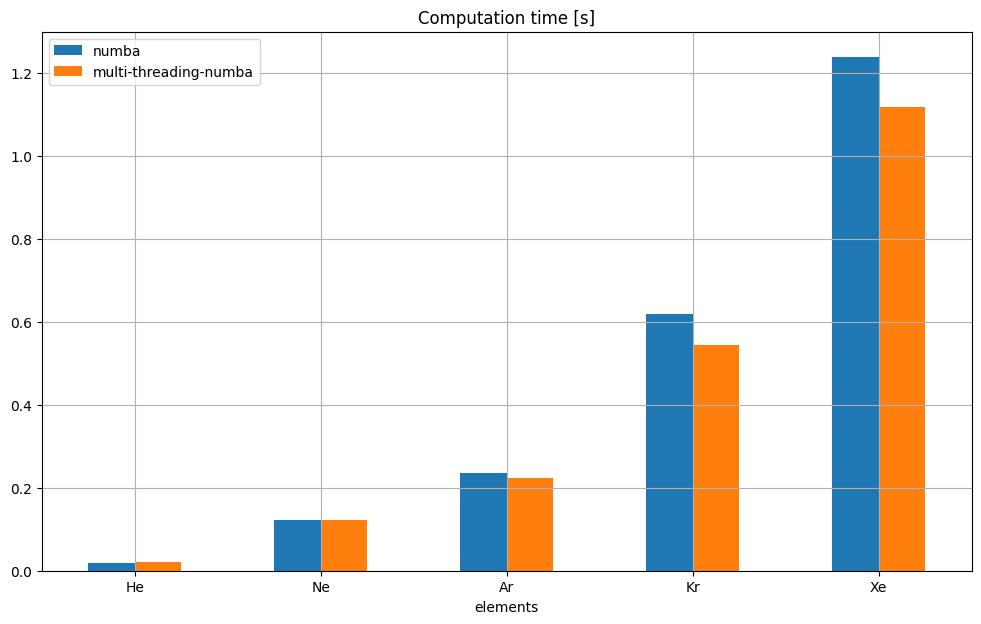

In [27]:
time_df.plot.bar(rot=0, title='Computation time [s]').grid()